**Time Trend Clusters in NYC Businesses**

In [1]:
import pandas as pd
import urllib2
import json
%pylab inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import pylab as pl
import pysal as ps
import mplleaflet
import zipfile
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


**1.  GET AND PREP DATA**

In [2]:
#Loading and concatenating Census files
census_years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
                '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
full_years = ['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', 
              '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
census_files = []
census_est = {}

for i in census_years:
    file_path = 'zbp%stotals.zip' % i
    census_zip = zipfile.ZipFile(file_path) 
    census_year = pd.read_csv(census_zip.open(file_path.replace('.zip','.txt')))
    census_year.columns = [x.upper() for x in census_year.columns]
    census_year = census_year[['ZIP', 'EST']]
    census_year = census_year.rename(columns = {'EST':i})
    census_files.append(census_year)

census_est[0] = census_files[0]

for i in range(1,20):
    census_est[i] = pd.merge(census_files[i], census_est[i-1], on=['ZIP']) 
    
census_df = census_est[19]
census_df = census_df.set_index('ZIP', drop = True)
census_df = census_df.reindex_axis([['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
                                     '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']], axis=1)
census_df.columns = full_years
census_df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ZIP,,,,,,,,,,,,,,,,,,,,
1001,439,439,433,457,444,469,493,490,490,505,500,509,509,503,477,458,448,436,453,439
1002,450,467,487,500,490,558,563,587,566,586,584,589,582,596,584,571,570,558,572,572
1003,10,10,13,15,14,13,13,13,15,16,15,12,12,16,17,16,16,16,15,15
1004,47,48,47,41,31,35,48,37,23,21,43,31,30,20,18,18,21,19,16,16
1005,92,95,101,104,95,82,86,90,94,93,97,94,98,106,97,87,96,91,94,97


In [3]:
#Loading GeoJSON file
zip_url = 'https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson'
request = urllib2.urlopen(zip_url)
zip_data = json.load(request)

In [4]:
#Getting list of zipcodes from GeoJSON file
ziplist = []

for i in range(len(zip_data['features'])):
    zipcode = zip_data['features'][i]['properties']['postalCode']
    ziplist.append(zipcode)
    
ziplist = map(int, ziplist)

In [5]:
#Excluding non-NYC data
census_mask = census_df.index.isin(ziplist)
census_df = census_df[census_mask]
census_df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ZIP,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


CHECK: 20 timestamps, ~250 ZIP codes

In [6]:
census_df.describe

# 20 years, 230 ZIP codes

<bound method DataFrame.describe of        1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  \
ZIP                                                                             
10001  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370  7312   
10002  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551  2682   
10003  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776  3867   
10004  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283  1260   
10005  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226  1214   
10006  1061  1002   969   990  1030  1059  1067  1026   934   862   869   870   
10007  1307  1274  1254  1287  1282  1303  1327  1233  1620  1603  1635  1311   
10009   634   633   673   747   786   804   860   869   921   953   982  1029   
10010  3019  2987  3029  3112  3152  3143  3203  3178  3085  3045  3059  3060   
10011  3301  3340  3392  3541  3599  3664  3653  3592  3682  3711  3729  

In [7]:
#Converting dataframe into matrix
census_matrix = census_df.as_matrix()
census_matrix

array([[6999, 7088, 7075, ..., 7227, 7235, 7273],
       [1784, 1819, 1919, ..., 2912, 2954, 2988],
       [3256, 3377, 3417, ..., 4159, 4214, 4277],
       ..., 
       [  95,   90,   88, ...,  131,  129,  127],
       [ 294,  285,  287, ...,  326,  326,  327],
       [  33,   32,   34, ...,   46,   49,   40]], dtype=int64)

In [8]:
#Performing z-score normalization of each time series
census_norm = np.zeros(census_matrix.shape)

for i in range(len(census_matrix)):
    census_norm[i] = stats.zscore(census_matrix[i])
    
print census_norm.shape
print census_norm.mean(axis=1)
print census_norm.std(axis=1)

(230L, 20L)
[ -2.72004641e-15  -4.55191440e-16   2.33146835e-16   7.88258347e-16
  -1.64868119e-15   2.77555756e-16  -3.21964677e-16   1.11022302e-16
   1.27675648e-15  -1.05471187e-15   1.11022302e-17   4.16680579e-16
   4.44089210e-16   6.27969898e-17   1.57651669e-15   8.88178420e-16
   3.33066907e-17   6.43929354e-16   2.22044605e-17   1.05471187e-15
   2.44249065e-15   1.11022302e-17  -3.10862447e-16  -2.22044605e-17
  -4.66293670e-16  -2.77555756e-18  -1.44328993e-16  -3.44169138e-16
  -5.21804822e-16   4.44089210e-17  -7.21644966e-16   4.44089210e-17
  -9.99200722e-17  -1.47659662e-15  -3.33066907e-17  -1.11022302e-17
  -4.44089210e-17  -5.99520433e-16   2.33146835e-16  -3.33066907e-17
  -1.77635684e-16   7.77156117e-17  -1.11022302e-17   2.22044605e-16
  -2.44249065e-16   1.53609764e-16  -1.66533454e-16   3.51108032e-16
  -5.32907052e-16   3.66373598e-16   4.66293670e-16   1.66533454e-17
   2.22044605e-17  -2.77555756e-16   3.27515792e-16  -2.44249065e-16
  -2.16493490e-16   3.

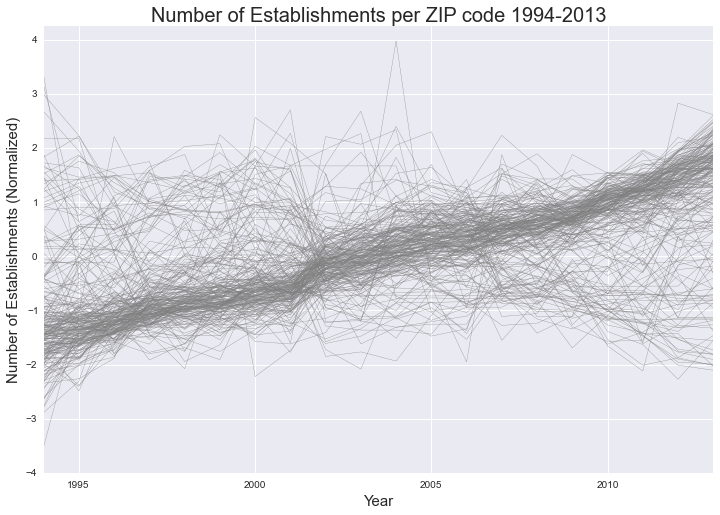

In [9]:
#Plotting the data
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color='gray', linewidth=0.3)
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("Number of Establishments per ZIP code 1994-2013", fontsize=20)

**2.  CLUSTER NUMBER OF ESTABLISHMENTS TIME SERIES WITH K-MEANS IN 'A FEW' CLUSTERS.  STARTING WITH THREE CUSTERS...**

**3.  PLOT CUSTER CENTERS (MEANS OF CLUSTERS).  YOU CAN PLOT, FOR EXAMPLE, THE CLUSTER CENTERS OVERLAYED ON EACH TIME SERIES.**

In [10]:
#K-means clustering; k=3
kmeans3 = KMeans(n_clusters=3, n_init=100)
kmeans3.fit(census_norm)
labels3 = kmeans3.labels_

#Calculating cluster centers
kc3_d = np.zeros((3,230))
kc3_m = np.zeros((3,230,20))
kc3 = np.zeros((3,20))

for k in range(3):
    
    for i in range(230):
        if labels3[i] == k:
            kc3_d[k][i] = 1
        else:
            kc3_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            kc3_m[k][b][a] = kc3_d[k][b]*census_norm[b][a]

    for i in range(20):
        kc3[k][i] = map(sum, kc3_m[k].transpose())[i]/kc3_d[k].sum()



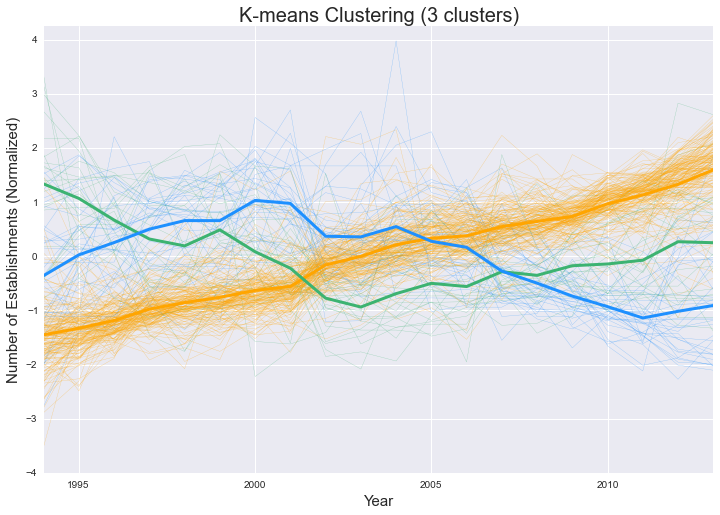

In [11]:
#Plotting 3 clusters        
colormap = ['orange', 'mediumseagreen', 'dodgerblue', 'black', 'slategrey']

pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labels3[i]], linewidth=0.3, alpha=0.5)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(3):
    pl.plot(full_years, kc3[i], '-', color=colormap[i], linewidth=3)

xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("K-means Clustering (3 clusters)", fontsize=20)

In [12]:
#K-means clustering; k=4

kmeans4 = KMeans(n_clusters=4, n_init=100)
kmeans4.fit(census_norm)
labels4 = kmeans4.labels_

#Calculating cluster centers
kc4_d = np.zeros((4,230))
kc4_m = np.zeros((4,230,20))
kc4 = np.zeros((4,20))

for k in range(4):
    
    for i in range(230):
        if labels4[i] == k:
            kc4_d[k][i] = 1
        else:
            kc4_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            kc4_m[k][b][a] = kc4_d[k][b]*census_norm[b][a]

    for i in range(20):
        kc4[k][i] = map(sum, kc4_m[k].transpose())[i]/kc4_d[k].sum()

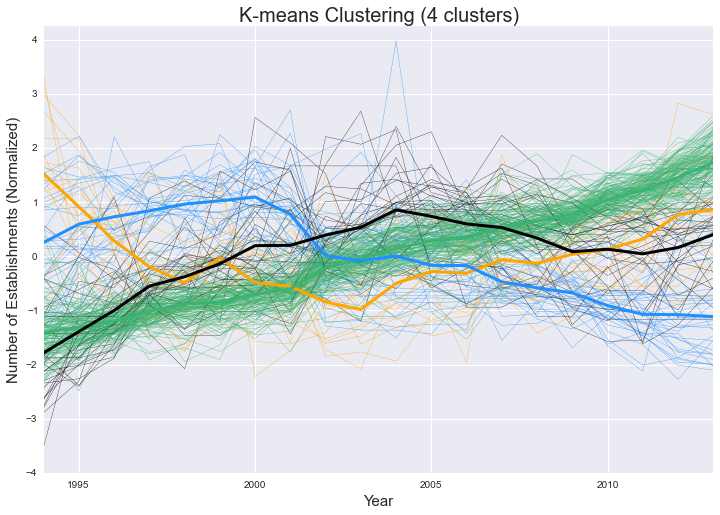

In [13]:
#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labels4[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(4):
    pl.plot(full_years, kc4[i], '-', color=colormap[i], linewidth=3)    
    
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("K-means Clustering (4 clusters)", fontsize=20)

In [14]:
#K-means clustering; k=5

kmeans5 = KMeans(n_clusters=5, n_init=100)
kmeans5.fit(census_norm)
labels5 = kmeans5.labels_

#Calculating cluster centers
kc5_d = np.zeros((5,230))
kc5_m = np.zeros((5,230,20))
kc5 = np.zeros((5,20))

for k in range(5):
    
    for i in range(230):
        if labels5[i] == k:
            kc5_d[k][i] = 1
        else:
            kc5_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            kc5_m[k][b][a] = kc5_d[k][b]*census_norm[b][a]

    for i in range(20):
        kc5[k][i] = map(sum, kc5_m[k].transpose())[i]/kc5_d[k].sum()

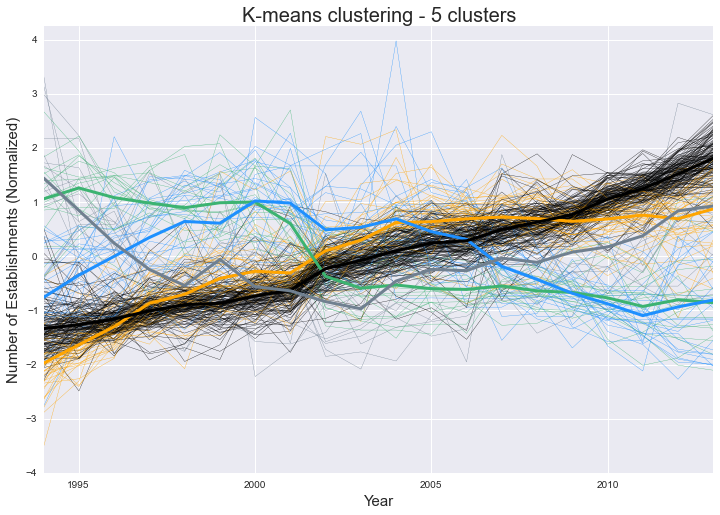

In [15]:
#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labels5[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(5):
    pl.plot(full_years, kc5[i], '-', color=colormap[i], linewidth=3)
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("K-means clustering - 5 clusters", fontsize=20)

**4.  USE ANOTHER CLUSTERING ALGORITHM (OF YOUR CHOICE).**

**Using agglomerative clustering, a 'bottom up' approach for complete linkage clustering**

In [16]:
#Agglomerative clustering (4 clusters)
agc = AgglomerativeClustering(n_clusters=4,  compute_full_tree=True).fit(census_norm)
labelsag = agc.labels_

#Calculating cluster centers
agc4_d = np.zeros((5,230))
agc4_m = np.zeros((5,230,20))
agc4 = np.zeros((5,20))

for k in range(4):
    
    for i in range(230):
        if labelsag[i] == k:
            agc4_d[k][i] = 1
        else:
            agc4_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            agc4_m[k][b][a] = agc4_d[k][b]*census_norm[b][a]

    for i in range(20):
        agc4[k][i] = map(sum, agc4_m[k].transpose())[i]/agc4_d[k].sum()

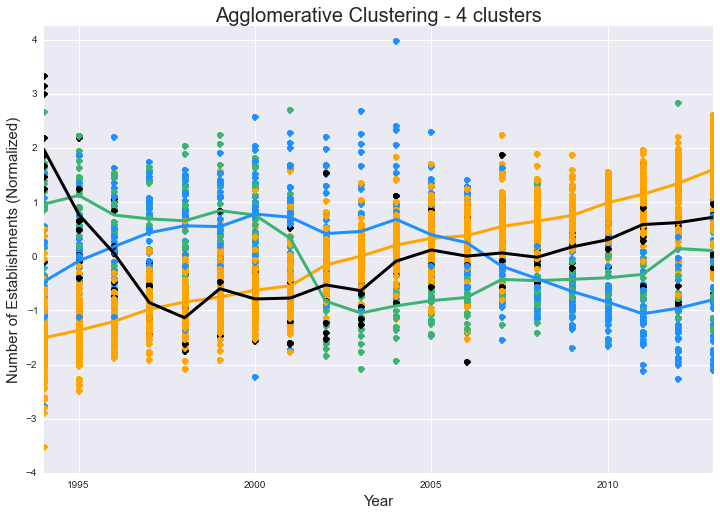

In [17]:
#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], 'o', color=colormap[labelsag[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(4):
    pl.plot(full_years, agc4[i], '-', color=colormap[i], linewidth=3)    
    
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("Agglomerative Clustering - 4 clusters", fontsize=20)

**5.  OVERLAY YOUR DATA ON A NYC MAP, USE SHAPEFILES FOR THE ZIP CODES AND DIFFERENT COLORS FOR DIFFERENT CLUSTERS.**

In [18]:
#Loading map as Geopandas and including columns for clusters
nyc_map = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

km_column = pd.DataFrame(columns=('postalCode', 'km_cluster'))
ag_column = pd.DataFrame(columns=('postalCode', 'ag_cluster'))

km_column['postalCode'] = census_df.index.astype(str)
km_column['km_cluster'] = labels4
ag_column['postalCode'] = census_df.index.astype(str) 
ag_column['ag_cluster'] = labelsag

nyc_map = pd.merge(nyc_map, km_column, on=['postalCode']) 
nyc_map = pd.merge(nyc_map, ag_column, on=['postalCode'])

nyc_map.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,km_cluster,ag_cluster
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.87440,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1,0
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.91390,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,1,0
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6269333.41234,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1,0
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.05770,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,0,3
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.59430,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,1,0


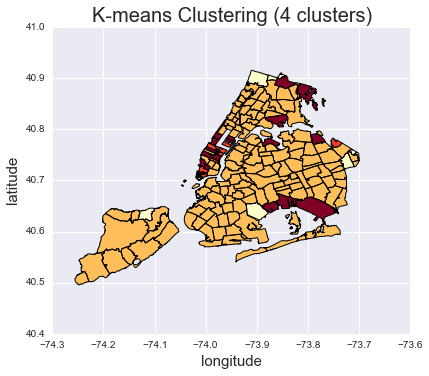

In [19]:
#Plotting k-means in map
pl.figure(figsize=(20, 20))
nyc_map.plot(column='km_cluster', alpha=1, colormap='YlOrRd')
pl.title("K-means Clustering (4 clusters)", fontsize=20)
pl.xlabel('longitude', fontsize = 15)
pl.ylabel('latitude', fontsize = 15)

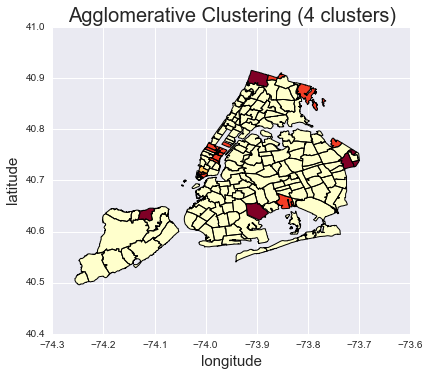

In [20]:
#Plotting k-means in map
pl.figure(figsize=(20, 20))
nyc_map.plot(column='ag_cluster', alpha=1, colormap='YlOrRd')
pl.title("Agglomerative Clustering (4 clusters)", fontsize=20)
pl.xlabel('longitude', fontsize = 15)
pl.ylabel('latitude', fontsize = 15)

**6.  COMPARE THE RESULTS OF THE 2 ALGORITHMS**

The algorithms show similar results with most of NYC following one trend and Northern Bronx, mid-town Manhattan, and outter Brookyn showing different trends from the rest.

**7.  ATTEMPT AN INTERPRETATION.  THIS IS DANGEROUS GROUND, CLUSTERING IS AN EXPLORATORY TOOL SO YOU DO NOT WANT TO**

Due to the fact that there are so few ZIP codes that don't follow the general pattern of the city, the recommendation is to investigate those areas more.  If they are increasing in # of establisments over the past 20 years it might be good to see if other secotrs of the city, i.e. housing, are growing as the same pace.  If they are decreasing, then more research will have to be conducted to see if the neighborhoods are in decline and why that is occuring.